In [1]:
%load_ext rpy2.ipython
%matplotlib inline
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of the log daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning).  We scraped this data using the [Wikipediatrend](https://cran.r-project.org/package=wikipediatrend) package in R.  Peyton Manning provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and superbowl appearances). The CSV is available [here](https://github.com/facebook/prophet/blob/master/examples/example_wp_log_peyton_manning.csv).

First we'll import the data:

In [2]:
import pandas as pd
from prophet import Prophet

In [3]:
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


We fit the model by instantiating a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [4]:
m = Prophet()
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.211542,7.444742,8.903545
3266,2017-01-16,8.536553,7.847804,9.211145
3267,2017-01-17,8.323968,7.541829,9.035461
3268,2017-01-18,8.156621,7.404457,8.830642
3269,2017-01-19,8.168561,7.438865,8.908668


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

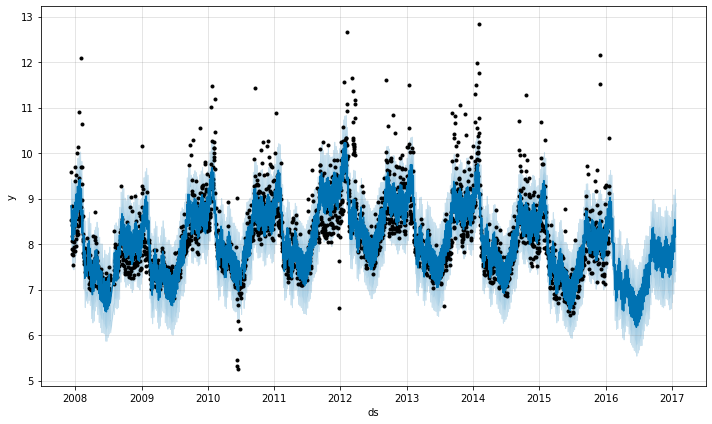

In [7]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

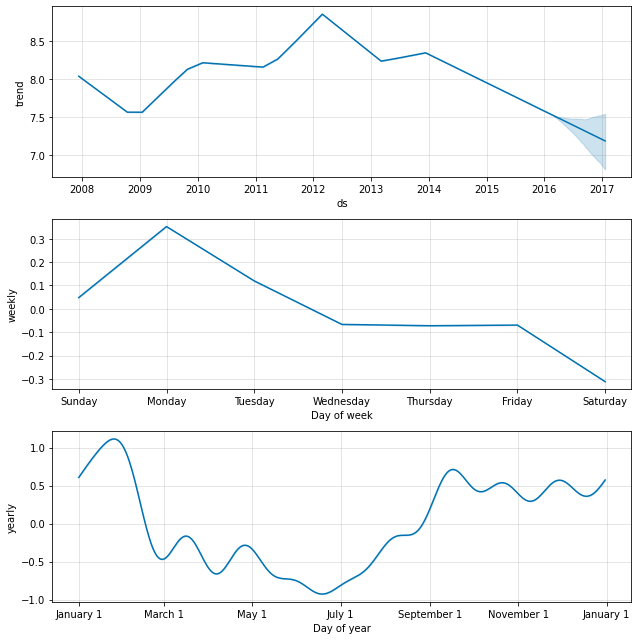

In [8]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the `notebook` and `ipywidgets` packages.

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

More details about the options available for each method are available in the docstrings, for example, via `help(Prophet)` or `help(Prophet.fit)`. The [R reference manual](https://cran.r-project.org/web/packages/prophet/prophet.pdf) on CRAN provides a concise list of all of the available functions, each of which has a Python equivalent.

## R API

In R, we use the normal model fitting API.  We provide a `prophet` function that performs fitting and returns a model object.  You can then call `predict` and `plot` on this model object.

In [2]:
%%R
library(prophet)

R[write to console]: Loading required package: Rcpp

R[write to console]: Loading required package: rlang



First we read in the data and create the outcome variable. As in the Python API, this is a dataframe with columns `ds` and `y`, containing the date and numeric value respectively. The ds column should be YYYY-MM-DD for a date, or YYYY-MM-DD HH:MM:SS for a timestamp. As above, we use here the log number of views to Peyton Manning's Wikipedia page, available [here](https://github.com/facebook/prophet/blob/master/examples/example_wp_log_peyton_manning.csv).

In [3]:
%%R
df <- read.csv('../examples/example_wp_log_peyton_manning.csv')

We call the `prophet` function to fit the model.  The first argument is the historical dataframe.  Additional arguments control how Prophet fits the data and are described in later pages of this documentation.

In [4]:
%%R
m <- prophet(df)

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Predictions are made on a dataframe with a column `ds` containing the dates for which predictions are to be made. The `make_future_dataframe` function takes the model object and a number of periods to forecast and produces a suitable dataframe. By default it will also include the historical dates so we can evaluate in-sample fit.

In [5]:
%%R
future <- make_future_dataframe(m, periods = 365)
tail(future)

             ds
3265 2017-01-14
3266 2017-01-15
3267 2017-01-16
3268 2017-01-17
3269 2017-01-18
3270 2017-01-19


As with most modeling procedures in R, we use the generic `predict` function to get our forecast. The `forecast` object is a dataframe with a column `yhat` containing the forecast. It has additional columns for uncertainty intervals and seasonal components.

In [6]:
%%R
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

             ds     yhat yhat_lower yhat_upper
3265 2017-01-14 7.818359   7.071228   8.550957
3266 2017-01-15 8.200125   7.475725   8.869495
3267 2017-01-16 8.525104   7.747071   9.226915
3268 2017-01-17 8.312482   7.551904   9.046774
3269 2017-01-18 8.145098   7.390770   8.863692
3270 2017-01-19 8.156964   7.381716   8.866507


You can use the generic `plot` function to plot the forecast, by passing in the model and the forecast dataframe.

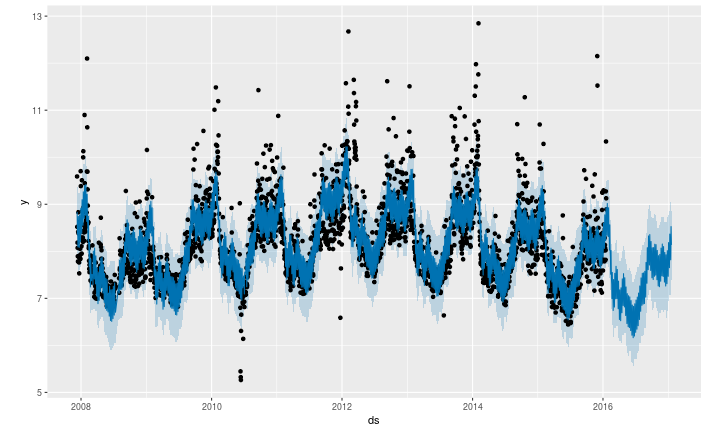

In [7]:
%%R -w 10 -h 6 -u in
plot(m, forecast)

You can use the `prophet_plot_components` function to see the forecast broken down into trend, weekly seasonality, and yearly seasonality.

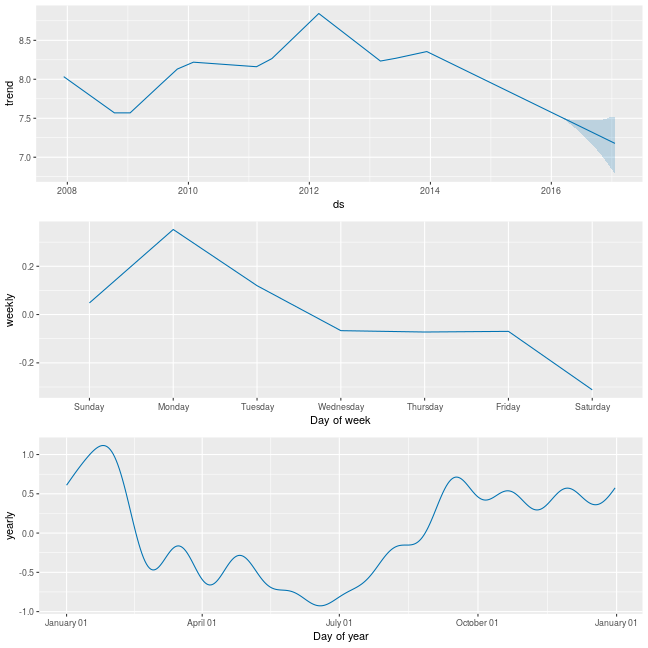

In [8]:
%%R -w 9 -h 9 -u in
prophet_plot_components(m, forecast)

An interactive plot of the forecast using Dygraphs can be made with the command `dyplot.prophet(m, forecast)`.

More details about the options available for each method are available in the docstrings, for example, via `?prophet` or `?fit.prophet`. This documentation is also available in the [reference manual](https://cran.r-project.org/web/packages/prophet/prophet.pdf) on CRAN.